# Translating images to text using GRUs

We will translate using classic deep learning.

The classic encoder-decoder model uses two Recurrent Neural Networks (RNN), the **encoder** and the **decoder**. 

The encoder encodes the source-text as a single vector of numbers, and the second RNN decodes this vector into the destination-text. 

The intermediate vector between the encoder and decoder is a kind of summary of the source-text, which is sometimes called a **thought-vector**, which usually captures semantics sources from a corpus of text. ***Semantically understanding*** the whole source-text before it is translated aligns encoder and decoder in their number-to-text transduction. However, in this case the semantics are very different: The encoder uses image semantics, so our thought-vector uses image-based semantics. this means that similar images will have thought vectors that are very *near* each other (e.g. very parallel to each other).

Here, we will replace the encoder with an image-recognition model. The image-model recognizes what the image contains and outputs that as a vector of numbers - our **thought-vector** or **summary-vector**. That vector is then input to the decoder, which decodes this vector into text.

Our decoder will consist of five GRU layers.

The VGG16 model has been pre-trained for *classifying* images. But instead of using the last classification layer, we will redirect the output of the previous layer. 

This gives us a vector with 4096 elements that summarizes the image-contents. We will use this vector as the initial state of a Gated Recurrent Units (GRU). The internal state-size of the GRU is only 512, so we need an intermediate fully-connected (dense) layer to map the vector with 4096 elements down to a vector with only 512 elements. That is something we are used to since that was the purpose of the final dense layer in our Transformer.

The decoder then uses this initial-state together with a start-sentinel `<start>`  and an end-sentinel `<end>`. to begin producing output words. 


### Importing Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
import pickle
from PIL import Image
#from cache import cache

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from os import listdir
from os.path import isfile, join
import os

## Data

In [ ]:
train_images_path = 'Flicker8k_Dataset'

In [ ]:
filenames_train = [f for f in listdir(train_images_path) if isfile(join(train_images_path, f))]
filenames_train[0:10]

['385186343_464f5fc186.jpg',
 '381976882_0063d16d88.jpg',
 '388386075_9ac3a89ada.jpg',
 '390986651_c801db91a0.jpg',
 '389643437_9a9830a3ba.jpg',
 '378170167_9b5119d918.jpg',
 '380527679_574749123d.jpg',
 '382151094_c7376cf22b.jpg',
 '387830531_e89c192b92.jpg',
 '381514859_b40418d9c3.jpg']

In [ ]:
def file_read(fname):
    content_array = []
    with open(fname) as f:
        #Content_list is the list that contains the read lines.     
        for line in f:
            content_array.append(line[:-1])
        return content_array

train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
filenames_caption = file_read(train_images_file)
filenames_caption[0:10]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg']

We verify that we aren't missing any files:

In [ ]:
for f in filenames_caption:
    if f not in filenames_train:
        print(f)

#### Images and captions

Let's read in our parallel corpus!


In [ ]:
def file_read_2(fname):
    content_array = []
    with open(fname) as f:
        #Content_list is the list that contains the read lines.     
        for line in f:
            jay_pee_gee = line.find('.jpg')
            first_space = line.find(' ')
            content_array.append((line[:jay_pee_gee + 4], line[first_space + 1: -3]))
        return content_array

caption_images_file = 'Flickr8k_text/Flickr8k.token.txt'
image_caption = file_read_2(caption_images_file)
image_caption[0:10]

[('1000268201_693b08cb0e.jpg',
  'child in a pink dress is climbing up a set of stairs in an entry way'),
 ('1000268201_693b08cb0e.jpg', 'girl going into a wooden building'),
 ('1000268201_693b08cb0e.jpg', 'little girl climbing into a wooden playhouse'),
 ('1000268201_693b08cb0e.jpg',
  'little girl climbing the stairs to her playhouse'),
 ('1000268201_693b08cb0e.jpg',
  'little girl in a pink dress going into a wooden cabin'),
 ('1001773457_577c3a7d70.jpg', 'black dog and a spotted dog are fighti'),
 ('1001773457_577c3a7d70.jpg',
  'black dog and a tri-colored dog playing with each other on the road'),
 ('1001773457_577c3a7d70.jpg',
  'black dog and a white dog with brown spots are staring at each other in the street'),
 ('1001773457_577c3a7d70.jpg',
  'dogs of different breeds looking at each other on the road'),
 ('1001773457_577c3a7d70.jpg', 'dogs on pavement moving toward each other')]

In [ ]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [ ]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        filename = image_caption[idx][0]
        caption = image_caption[idx][1]
    else:
        # Use an image from the validation-set.
        filename = image_caption[idx][0]
        caption = image_caption[idx][1]

    # Path for the image-file.
    path = os.path.join(train_images_path, filename)

    # Print the captions for this image.
    print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

In [ ]:
train_filenames = [image_caption[i][0] for i in range(len(image_caption))]
train_filenames[0:20]

['1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1003163366_44323f5815.jpg',
 '1003163366_44323f5815.jpg',
 '1003163366_44323f5815.jpg',
 '1003163366_44323f5815.jpg']

In [ ]:
train_captions = [image_caption[i][1] for i in range(len(image_caption))]
train_captions[0:20]

['child in a pink dress is climbing up a set of stairs in an entry way',
 'girl going into a wooden building',
 'little girl climbing into a wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in a pink dress going into a wooden cabin',
 'black dog and a spotted dog are fighti',
 'black dog and a tri-colored dog playing with each other on the road',
 'black dog and a white dog with brown spots are staring at each other in the street',
 'dogs of different breeds looking at each other on the road',
 'dogs on pavement moving toward each other',
 'little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'little girl is sitting in front of a large painted rainbow',
 'small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'is a girl with pigtails sitting in front of a rainbow painting',
 'girl with pigtails painting outside in the grass',
 'man lays on a bench while his dog sits b

### Example Image
Show an example image and captions from the training-set.

In [ ]:
image_caption[40]

('1015118661_980735411b.jpg', 'boy smiles in front of a stony wall in a city')

boy smiles in front of a stony wall in a city


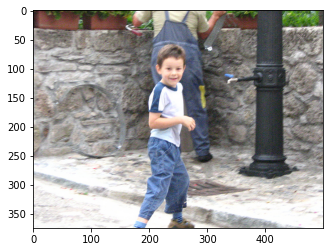

In [ ]:
show_image(idx=40, train=True)

### Pre-Trained Image Model (VGG16)
Let's create an instance of the VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected (dense) part which is used for the image classification.

If `include_top=True` then the whole VGG16 model is downloaded which is about 528 MB. If `include_top=False` then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

We will use some of the fully-connected layers in this pre-trained model

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 14s 0us/step


In [ ]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We will use the output of the layer prior to the final classification-layer which is named fc2. This is a fully-connected (or dense) layer

In [ ]:
transfer_layer = image_model.get_layer('fc2')

We call it the `transfer-layer` because we will transfer its output to another model that creates the image captions.

To do this, first we need to create a new model which has the same input as the original VGG16 model but outputs the transfer-values from the fc2 layer.

In [ ]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

The model expects input images to be of this size:

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

For each input image, the new model will output a vector of transfer-values with this length:

In [ ]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Processing All Images
We now make functions for processing all images in our data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save ourselves a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing progress.

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

This is the function for processing the given files using the VGG16-model and returning their transfer-values.

In [ ]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    We process the images in batches to save
    memory and improve efficiency on a GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # We use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Let's cache the results of a generic function for reuse:

In [ ]:
def cache(cache_path, fn, *args, **kwargs):
    """
    Cache-wrapper for a function or class. If the cache-file exists
    then the data is reloaded and returned, otherwise the function
    is called and the result is saved to cache. The fn-argument can
    also be a class instead, in which case an object-instance is
    created and saved to the cache-file.
    :param cache_path:
        File-path for the cache-file.
    :param fn:
        Function or class to be called.
    :param args:
        Arguments to the function or class-init.
    :param kwargs:
        Keyword arguments to the function or class-init.
    :return:
        The result of calling the function or creating the object-instance.
    """

    # If the cache-file exists.
    if os.path.exists(cache_path):
        # Load the cached data from the file.
        with open(cache_path, mode='rb') as file:
            obj = pickle.load(file)

        print("- Data loaded from cache-file: " + cache_path)
    else:
        # The cache-file does not exist.

        # Call the function / class-init with the supplied arguments.
        obj = fn(*args, **kwargs)

        # Save the data to a cache-file.
        with open(cache_path, mode='wb') as file:
            pickle.dump(obj, file)

        print("- Data saved to cache-file: " + cache_path)

    return obj

In [ ]:
def convert_numpy2pickle(in_path, out_path):
    """
    Convert a numpy-file to pickle-file.
    The first version of the cache-function used numpy for saving the data.
    Instead of re-calculating all the data, you can just convert the
    cache-file using this function.
    :param in_path:
        Input file in numpy-format written using numpy.save().
    :param out_path:
        Output file written as a pickle-file.
    :return:
        Nothing.
    """

    # Load the data using numpy.
    data = np.load(in_path)

    # Save the data using pickle.
    with open(out_path, mode='wb') as file:
        pickle.dump(data, file)

Here is an example of using a cache-file:

In [ ]:
# This is the function that will only get called if the result
# is not already saved in the cache-file. This would normally
# be a function that takes a long time to compute
def expensive_function(a, b):
    return a * b

print('Computing expensive_function() ...')

# Either load the result from a cache-file if it already exists,
# otherwise calculate expensive_function(a=123, b=456) and
# save the result to the cache-file for next time.
result = cache(cache_path=os.path.join(train_images_path, 'cache_expensive_function.pkl'),
               fn=expensive_function, a=123, b=456)

print('result =', result)

Computing expensive_function() ...
- Data saved to cache-file: Flicker8k_Dataset/cache_expensive_function.pkl
result = 56088


## Model


In [ ]:
train_filenames = train_filenames[0:6500]
train_captions = train_captions[0:6500]

This is a helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

In [ ]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for our cache-file.
    cache_path = os.path.join(train_images_path, "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                        fn=process_images,
                        data_dir=train_images_path,
                        filenames=train_filenames)

    return transfer_values

In [ ]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 8095 images in training-set ...
- Progress: 99.9%
- Data saved to cache-file: Flicker8k_Dataset/transfer_values_train.pkl
dtype: float16
shape: (6500, 4096)
CPU times: user 1min 25s, sys: 6.12 s, total: 1min 31s
Wall time: 11min 46s


### Tokenizing
We use two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a an embedding-layer. 

We first need to mark the beginning and end of each text-sequence with our start and end sentinels.

In [ ]:
# for  single caption per image
def mark_captions(captions_list):
    captions_marked = [['startsentence ' + caption + ' endsentence'
                        for caption in captions_list]]
    
    return captions_marked

Now process all the captions in the training-set and show an example

In [ ]:
captions_train_marked = mark_captions(train_captions)
captions_train_marked[0][200]

'startsentence constructions workers sit on a beam taking a break endsentence'

We can flatten our list of lists into a flat list, you could do it this way:

In [ ]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

captions_train_flat = flatten(captions_train_marked)
captions_train_flat[0:10]

['startsentence child in a pink dress is climbing up a set of stairs in an entry way endsentence',
 'startsentence girl going into a wooden building endsentence',
 'startsentence little girl climbing into a wooden playhouse endsentence',
 'startsentence little girl climbing the stairs to her playhouse endsentence',
 'startsentence little girl in a pink dress going into a wooden cabin endsentence',
 'startsentence black dog and a spotted dog are fighti endsentence',
 'startsentence black dog and a tri-colored dog playing with each other on the road endsentence',
 'startsentence black dog and a white dog with brown spots are staring at each other in the street endsentence',
 'startsentence dogs of different breeds looking at each other on the road endsentence',
 'startsentence dogs on pavement moving toward each other endsentence']

We set the maximum number of words in our vocabulary. We will only use e.g. the 25000 most frequent words in the captions from the training-data.

In [ ]:
num_words = 25000

We wrap `keras`' `Tokenizer` class:

In [ ]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

Let's create a tokenizer using all the captions in the training-data. Note that you will need to use the flattened list version to create the tokenizer because it cannot take a list-of-lists.

In [ ]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat, num_words=num_words)

CPU times: user 102 ms, sys: 915 µs, total: 102 ms
Wall time: 102 ms


In [ ]:
token_start = tokenizer.word_index['startsentence']
token_start

1

In [ ]:
token_end = tokenizer.word_index['endsentence']
token_end

2

Let's convert all the captions from the training-set to sequences of integer-tokens. We end up with a list-of-lists.

In [ ]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 78.5 ms, sys: 914 µs, total: 79.4 ms
Wall time: 78.6 ms


In [ ]:
captions_train_flat[200]

'startsentence constructions workers sit on a beam taking a break endsentence'

In [ ]:
tokens_train[0][200]

[1, 2174, 836, 134, 6, 3, 641, 228, 3, 837, 2]

In [ ]:
tokens_train[0][1]

[1, 14, 347, 44, 3, 168, 155, 2]

### Data Generator
Our neural network will be trained with batches of transfer-values for the images, and multiple sequences of integer-tokens for the captions. 

If we want matching numpy arrays for the training-set, we would either have to use a single caption for each image and ignore the rest, or we would have to repeat the image transfer-values for each of the captions.

This helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [ ]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

For a simple one-caption-per-image dataset

In [ ]:
def get_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has a unique caption
        # which has been converted to tokens in tokens_train.
        # The reason we use [0] is because we have used a list
        # of lists for flickr8k as well, in order to keep the
        # same structure for our miniature and large models
        tokens = tokens_train[0][i]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

Now we're ready to create random batches of training-data, using a Keras generator, to train our neural network with.

Note that we select the data completely randomly for each batch, corresponding to sampling of the training-set **with
replacement**. 

This means it is possible to sample the same data multiple times within a single epoch - and it is also possible that some data is not sampled at all within an epoch. However, the data is unique within a single batch.

We select a batch of images and captions, we pad the sequences to a fixed length, the decoder's input data and output data are shifted by one time-step, and we employ dictionaries for the encoder and decoder vocabularies.

Don't forget to set the `num_images_train` variable to the number of  images in your model. In our miniature-minature flickr8k corpus, we have 6,500 images.

In [ ]:
num_images_train = 6500

In [ ]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.

        # use this for flickr8k
        tokens = get_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

Now we can set the batch-size to be used during training. 



In [ ]:
batch_size = 300

Create an instance of our data generator:

In [ ]:
generator = batch_generator(batch_size=batch_size)

### Steps Per Epoch
One **epoch** is a complete processing of the training-set. 

We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an **epoch** to measure approximately how many iterations of the training-data we have processed. 

This would be the number of captions for each image in the training-set:

In [ ]:
steps_per_epoch = 200

### Create the Recurrent Neural Network¶
We are now ready to create the Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be translated into text. 

We call this neural network the **decoder** as it is almost identical to the decoder when doing Machine Translation.

Note that as usual we are using the functional model from Keras to build the neural network, because it allows more flexibility in how the neural network can be connected, in case you want to experiment and connect the image-model directly to the decoder 

This means we have split the network construction into two parts: (1) Creation of all the layers that are not yet connected, and (2) a function that connects all these layers.

The decoder consists of 5 GRU layers whose internal state-sizes are:

In [ ]:
state_size = 1500

The embedding-layer converts integer-tokens into vectors of this length:

In [ ]:
embedding_size = 256

This inputs transfer-values to the decoder:

In [ ]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

We want to use the transfer-values to initialize the internal states of the GRU units. 

This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512!

So we need to use a fully-connected layer to map the vectors from 4096 to 512 elements.

Note that we use a `tanh` activation function to limit the output of the mapping between -1 and 1, otherwise this does not seem to work.

In [ ]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

This is the input for token-sequences to the decoder. As usual, using `None` in the shape means that the token-sequences can have arbitrary lengths.

In [ ]:
decoder_input = Input(shape=(None, ), name='decoder_input')

This is the keras embedding-layer which converts sequences of **integer**-tokens to vectors which are sequences of **floats**.

In [ ]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

Ok, let's create the 5 GRU layers of the decoder. 

Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [ ]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)
decoder_gru4 = GRU(state_size, name='decoder_gru4',
                   return_sequences=True)
decoder_gru5 = GRU(state_size, name='decoder_gru5',
                   return_sequences=True)

The GRU layers output a tensor with shape [batch_size, sequence_length, state_size], where each **word** is encoded as a vector of length `state_size`. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

One way of doing this is to convert the GRU output to a one-hot encoded array. It works but it is somewhat wasteful, because for a vocabulary of e.g. 25,000 words we need a vector with 25,000 elements, so we can select the index of the highest element to be the integer-token.

In [ ]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

### Connect and Create the Training Model

The decoder is built using the functional API of Keras, which allows flexibility in connecting the layers e.g. to have multiple inputs. This is useful for example if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values. 

Here, we will do it with just a function call. This function connects all the layers of the decoder to some input of transfer-values:

In [ ]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    net = decoder_gru4(net, initial_state=initial_state)
    net = decoder_gru5(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

Let's connect and create the model used for training. 

Our model takes as input transfer-values, and sequences of integer-tokens. It outputs sequences of one-hot encoded arrays that can subsequently be converted into integer-tokens.

In [ ]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Model compile
The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

But our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 25000 elements so it would be wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in `batch_generator()` above.

A better way is to use a **sparse cross-entropy** loss-function, which does the conversion internally from integers to one-hot encoded arrays.

We will use the `RMSprop` optimizer, but yu should plan on using the `Adam` optimizer for coco. Note that Adam is known to diverge in some experiments with Recurrent Neural Networks.

In [ ]:
decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss='sparse_categorical_crossentropy')

### Checkpointing

During training we want to save checkpoints.

In [ ]:
path_checkpoint = 'training_checkpoints/vgg16/checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [ ]:
callback_tensorboard = TensorBoard(log_dir='/training_checkpoints/vgg16/logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callbacks = [callback_checkpoint]

### Loading Checkpoint¶
This is how you can reload the last saved checkpoint so you don't have to train the model every time you want to use it. If you run it now, your will exception out because we have not checkpointed, yet.

In [ ]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Train the Model
We will train the decoder so it can map transfer-values from the image-model over to sequences of integer-tokens for the captions of the images.

In [ ]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=60,
                  )

Epoch 1/60
200/200 [==============================] - 95s 445ms/step - loss: 3.5494
Epoch 2/60
200/200 [==============================] - 91s 453ms/step - loss: 2.4572
Epoch 3/60
200/200 [==============================] - 91s 456ms/step - loss: 1.9024
Epoch 4/60
200/200 [==============================] - 90s 448ms/step - loss: 1.4235
Epoch 5/60
200/200 [==============================] - 90s 452ms/step - loss: 1.0937
Epoch 6/60
200/200 [==============================] - 90s 448ms/step - loss: 0.8493
Epoch 7/60
200/200 [==============================] - 91s 453ms/step - loss: 0.6600
Epoch 8/60
200/200 [==============================] - 90s 452ms/step - loss: 0.5340
Epoch 9/60
200/200 [==============================] - 90s 448ms/step - loss: 0.4644
Epoch 10/60
200/200 [==============================] - 90s 450ms/step - loss: 0.4015
Epoch 11/60
200/200 [==============================] - 92s 458ms/step - loss: 0.3476
Epoch 12/60
200/200 [==============================] - 90s 450ms/step - lo

## Inference
Let's load an image and translate it to a caption using our trained model.

In [ ]:
def translate(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

Let's try it out:

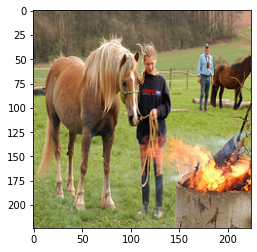

Predicted caption:
 girl holding a horse 's lead behind a fire endsentence



In [ ]:
translate("Flicker8k_Dataset/10815824_2997e03d76.jpg")

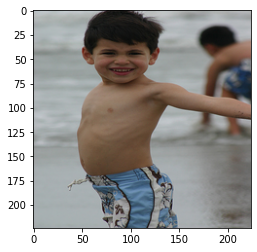

Predicted caption:
 boy is playing on the shore of an ocean endsentence



In [ ]:
translate("Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg")

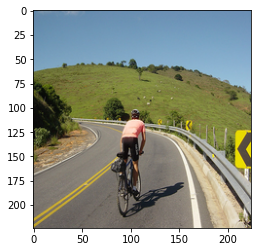

Predicted caption:
 man on a mountain bike is pedaling up a hill endsentence



In [ ]:
translate("Flicker8k_Dataset/110595925_f3395c8bd6.jpg")

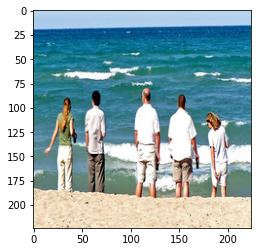

Predicted caption:
 ladies and three men looking at the ocean endsentence



In [ ]:
translate("Flicker8k_Dataset/160792599_6a7ec52516.jpg")

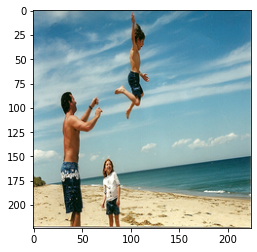

Predicted caption:
 boy is playing with a water spout outdoors while the rest of his family watches endsentence



In [ ]:
translate("Flicker8k_Dataset/459778335_857d8ffebf.jpg")

## Conclusion

The model translates images with a pre-trained image-model (VGG16), generating a **thought-vector** of what the image contains, and then trains a 5-layer sandwich of GRUs to map this thought-vector to a sequence of words.

This model does not have a human-like understanding of what the images contain. If it sees an image of a giraffe and correctly produces a caption stating that, it doesn't mean that the model has a deep understanding of what a giraffe is.

The model is merely a clever way of mapping pixels in an image to a vector of floating-point numbers that summarize the contents of the image, and then maps these numbers to a sequence of integers-tokens representing words. So the model is  just a very advanced function approximator.

>**Note**: ML is just statistics, not human-like intelligence

## License


Copyright 2020 Swin Sanjao Almeida

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## References

1. https://arxiv.org/pdf/1502.03044.pdf

2. https://arxiv.org/pdf/1409.0473.pdf

3. https://github.com/kelvinxu/arctic-captions
